# Developing JuliaFEM

Author(s): Jukka Aho

**Abstract**: Developer notes. In this notebook we give the general guidelines how to implement basic fundamentals to JuliaFEM. The notebook is rapidly updated and should always represent the newest "style" how to develop things to JuliaFEM. At this phase of project interfaces are changing rapidly. For this reason we aim to develop couple of simple functions aiming to test that elements, equations, solvers etc. work as expected, in the sense that their interface hasn't any design problems. (Yes, we do believe in testing and follow also other practices proven to be good, like continuous integration). The aim of this document is not to be the guide to "other contributors" but is more like an guide line for all contributors, including ourselves, how things should be done.

For demonstrational purposes the Poisson equation is used in examples to demonstrate the main concepts of the package. Poisson equation has some analogies to solid mechanics. Consider for example $(EAu')' + q = 0$, what is nothing more than a Poisson equation defined in 1d.

Because this is the second important document in this source repository, any questions or suggestions araising from this notebook are very welcome and desirable and should be adressed to the our issue log: https://github.com/JuliaFEM/JuliaFEM.jl/issues. Easiest way to make the world better is to register GitHub (takes 1 min) and drop an issue. And the most important document? It's the "how to contribute" guide, see https://github.com/JuliaFEM/JuliaFEM.jl/blob/master/CONTRIBUTING.rst.

In this notebook the following types are briefly described:

**Element**: object which holds basis functions and fields. One is able to interpolate fields using element. Introduction of new basis functions needs new elements. Typical elements: Lagrange elements, hierarchical elements, etc.

**Equation**: object holding some field equation, like Poisson equation $\Delta u = f$, elasticity equation $\nabla \cdot \sigma = f$, etc., "solvable". This is the physics we are solving by approximating the equations in the element area by basis functionsprovided by element.

**Problem**: object which maps equations to elements. For example, HeatProblem maps Poisson equation to Lagrange elements and ElasticityProblem maps elasticity equation to Lagrange elements.

**Solver**: object takes one or more problems, solves them using some strategy (iterative methods, multigrid, direct methods, ...) and updates corresponding fields to elements. The is the section where any numerical crunching happens and is targeted to high-performance computing. 

These concepts are quite well separated so that development process can focus to point of interest. In this notebook we will give instructions to all of the sections describing the whole development process from element level to global assembly and solution.

We have
- [x] **`test_element`**
- [ ] **`test_equation`**
- [ ] **`test_problem`** 
- [ ] **`test_solver`**

what can be used to test that implementation has all necessary things defined.


Poisson equation is used in this notebook to demonstrate all phases of development process. It's weak form is: find $u\in\mathcal{U}$ such that
\begin{equation}
    \int_{\Omega}\nabla u\cdot\nabla v\,\mathrm{d}x=\int_{\Omega}fv\,\mathrm{d}x+\int_{\Gamma_{\mathrm{N}}}gv\,\mathrm{d}s\quad\forall v\in\mathcal{V}.
\end{equation}

## Definitions / nomenclature

- weighted residual form: differential equation is multiplied by a weight function and integrating it.
- weak form, "principle of virtual work": typically established by partial integration of a weighted residual form. $\delta\mathcal{W}_{\mathrm{int}}=\delta\mathcal{W}_{\mathrm{ext}}$.
- variational form, "principle of minimum potential energy": there exists some functional  or "potential function" $\Pi$ we are minimizing

## Developing own element

Element contains basis functions and one or several fieldsets.

Minimum requirements for element:
- subclass it from Element, unless want to implement everything by youself
- define basis and partial derivatives of it, because we need to interpolate over it
- give connectivity information, how this element is connected to other elements

Test the element using ``test_element`` function. It it passes, the element implementation should be fine.

In [1]:
using JuliaFEM: Element, Basis, FieldSet

Here's the basic implementation for element:

In [2]:
type MyQuad4 <: Element
    connectivity :: Array{Int, 1}
    basis :: Basis
    fields :: FieldSet
end

Default constructor takes only connectivity information as input argument. Most important thing here is to define `Basis` which is used to interpolate fields.

In [3]:
function MyQuad4(connectivity)
    h(xi) = 1/4*[(1-xi[1])*(1-xi[2])   (1+xi[1])*(1-xi[2])   (1+xi[1])*(1+xi[2])   (1-xi[1])*(1+xi[2])]
    dh(xi) = 1/4*[
        -(1-xi[2])    (1-xi[2])   (1+xi[2])  -(1+xi[2])
        -(1-xi[1])   -(1+xi[1])   (1+xi[1])   (1-xi[1])]
    basis = Basis(h, dh)
    MyQuad4(connectivity, basis, Dict())
end

MyQuad4

Also some basic information like number of basis functions and element dimension is needed. We can set them directly to the `Base.size`:

In [4]:
Base.size(element::Type{MyQuad4}) = (2, 4)  # 2 => (ξ₁, ξ₂), 4 => 4 basis functions

size (generic function with 81 methods)

Here comes one important thing. We always define our "things" so that the first index is dimension, like $(x, y, z)$ or $(\xi_1, \xi_2, \xi_3)$ and second index is basis function number / node id or something similar to that. To motivate this, consider the following example:

In [5]:
x = [1 2; 3 4; 5 6; 7 8]'

2x4 Array{Int64,2}:
 1  3  5  7
 2  4  6  8

Here, if we consider $x$ as of some field e.g. geometry, our coordinates of first node is $(1, 2)$, second is $(3, 4)$ and so on. Typically on vector field problems the global assembly is something like $(u_1, v_1, u_2, v_2, \ldots, )$. If fields are defined this way we can easily flatten matrix to vector and back:

In [6]:
dim = size(x)
x2 = vec(x)

8-element Array{Int64,1}:
 1
 2
 3
 4
 5
 6
 7
 8

In [7]:
reshape(x2, dim)

2x4 Array{Int64,2}:
 1  3  5  7
 2  4  6  8

Also:

In [8]:
for i=1:8
    print("$(x[i]) ")
end

1 2 3 4 5 6 7 8 

So when keeping this order, things automatically go right in Julia.

Next we check that everything is well defined:

In [9]:
using JuliaFEM: test_element
test_element(MyQuad4)

INFO: Testing element MyQuad4
INFO: element dimension: 2 x 4
INFO: Initializing element
INFO: basis at [0.0,0.0]: [0.25 0.25 0.25 0.25]
INFO: field val at [0.0,0.0]: 2.5
INFO: derivative of basis at [0.0,0.0]:
[-0.5 0.5 0.5 -0.5
 -0.5 -0.5 0.5 0.5]
INFO: field val at [0.0,0.0]: [0.0 2.0]
INFO: Element MyQuad4 passed tests.


If `test_element` passes, elements *interface* should be well defined. After building element, one can interpolate things in it. Here we create three new fields `temperature`, `geometry` and `heat coefficient`, add some values for them in time $t=0.0$ and $t=1.0$ and interpolate. The concept of fields is described in [another notebook](https://github.com/JuliaFEM/JuliaFEM.jl/blob/master/docs/tutorials/2015-06-14-data-structures.ipynb), and we are not particularly focusing on them here. Here's some examples how to store data to element.

In [10]:
using JuliaFEM: Field, TimeStep, Increment
element = MyQuad4([1, 2, 3, 4])

# create one timestep for t=0
# is equivalent to 
# element["geometry"] = (0.0 => Vector[[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]])
element["geometry"] = Vector[[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]]

# create two timesteps, one for t=0.0 and another for t=1.0
element["temperature"] = (0.0, [0.0, 0.0, 0.0, 0.0]), (1.0, [1.0, 2.0, 3.0, 4.0])

# create two timesteps, one is zeros at time t=0.0 and another with t=1.0
element["displacement"] = (
    0.0 => Vector[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]],
    1.0 => Vector[[0.0, 0.0], [0.0, 0.0], [1/4, 0.0], [0.0, 0.0]])

# create two timesteps, one for t=0.0 and another for t=1.0
element["heat coefficient"] = (0.0, 2), (1.0, 3)
element.fields

Dict{ASCIIString,JuliaFEM.Field} with 4 entries:
  "geometry"         => JuliaFEM.DefaultDiscreteField([JuliaFEM.TimeStep(0.0,Ju…
  "heat coefficient" => JuliaFEM.DefaultDiscreteField([JuliaFEM.TimeStep(0.0,Ju…
  "displacement"     => JuliaFEM.DefaultDiscreteField([JuliaFEM.TimeStep(0.0,Ju…
  "temperature"      => JuliaFEM.DefaultDiscreteField([JuliaFEM.TimeStep(0.0,Ju…

In [11]:
# geometry midpoint of element
using JuliaFEM: get_basis, grad
basis = get_basis(element)
basis("geometry", [0.0, 0.0], 0.0)

2-element Array{Float64,1}:
 0.5
 0.5

In [12]:
# interpolate derivatives works too
dbasis = grad(basis)
# temperature gradient at mid point of element at time t=0.5
dbasis("temperature", [0.0, 0.0], 0.5)

1x2 Array{Float64,2}:
 0.0  1.0

In [13]:
# interpolating scalar -> scalar.
basis("heat coefficient", [0.0, 0.0], 0.5)

2.5

In [14]:
# set time to Inf to get very last field value and -Inf to get first one.
basis("heat coefficient", [0.0, 0.0], Inf)

3

In [15]:
# some continuum mechanics
∇u = dbasis("displacement", [0.0, 0.0], 1.0)
ɛ = 1/2*(∇u + ∇u')
Ω = 1/2*(∇u - ∇u')
X = basis("geometry", [0.0, 0.0], 1.0)
F = I + ∇u
C = F'*F
E = 1/2*(F'*F - I)  # Green-Lagrange strain tensor

2x2 Array{Float64,2}:
 0.132813   0.0703125
 0.0703125  0.0078125

Basically one could already write local stiffness matrices:

In [16]:
weights = [1.0, 1.0, 1.0, 1.0]
integration_points = 1.0/sqrt(3.0)*Vector[[-1, -1], [1, -1], [1, 1], [-1, 1]]

M = zeros(4, 4)
K = zeros(4, 4)
f = zeros(4)
k = 6
rho = 36
q = 4

for (w, xi) in zip(weights, integration_points)
    basis = get_basis(element)
    dbasis = grad(basis)  # gradient is with respect to "geometry" field
    detJ = det(basis)
    M += w*rho*basis(xi)'*basis(xi)*detJ(xi)  # mass matrix
    K += w*k*dbasis(xi)'*dbasis(xi)*detJ(xi)  # stiffness matrix
    f += w*basis(xi)'*q*detJ(xi)  # force vector
end
K, M, f

(
4x4 Array{Float64,2}:
  4.0  -1.0  -2.0  -1.0
 -1.0   4.0  -1.0  -2.0
 -2.0  -1.0   4.0  -1.0
 -1.0  -2.0  -1.0   4.0,

4x4 Array{Float64,2}:
 4.0  2.0  1.0  2.0
 2.0  4.0  2.0  1.0
 1.0  2.0  4.0  2.0
 2.0  1.0  2.0  4.0,

4x1 Array{Float64,2}:
 1.0
 1.0
 1.0
 1.0)

but we have something better than that. Keep on reading!

### Summary of developing own elements

Element itself if not calculating anything but only stores fields and basis functions so that the fields can be interpolated. We will provide command `test_element` which will ensure that everything necessary is defined. While a lot of things needs to be defined, by subclassing from `Element` most of these are already defined, thanks to multiple dispatch.

## Developing own equation

Let's consider a Poisson equation
\begin{align}
-\nabla \cdot \left( k \nabla u\right) &= f && \text{on } \Omega \\
\frac{\partial u}{\partial n} &= g && \text{on } \Gamma_{\mathrm{N}} \\
u &= u_0 && \text{on } \Gamma_{\mathrm{D}}
\end{align}

Weak form is, find $u\in\mathcal{U}$ such that
\begin{equation}
    \int_{\Omega}k \nabla u\cdot\nabla v\,\mathrm{d}x = \int_{\Omega}fv\,\mathrm{d}x + \int_{\Gamma_{\mathrm{N}}}gv\,\mathrm{d}s \quad\forall v\in\mathcal{V}.
\end{equation}

Minimum requirements for equation: 
- subclass from Equation, if not want to implement from scratch
- provide the name of the unknown field variable trying to solve
- default constructor takes the element as input argument

This time we will have function `test_equation`, which we can use to test that everything is working as expected. 

In [17]:
using JuliaFEM: Equation, IntegrationPoint, Quad4, Seg2

abstract Heat <: Equation

Basic data type needs to contain element, integration points and global degrees of freedom for global assembly:

In [18]:
""" Diffusive heat transfer for 4-node bilinear element. """
type DC2D4 <: Heat
    element :: Quad4
    integration_points :: Array{IntegrationPoint, 1}
end
function DC2D4(element::Quad4)
    integration_points = [
        IntegrationPoint(1.0/sqrt(3.0)*[-1, -1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[ 1, -1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[ 1,  1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[-1,  1], 1.0)]
    if !haskey(element, "temperature")
        element["temperature"] = []
    end
    DC2D4(element, integration_points)
end
Base.size(equation::DC2D4) = (1, 4)

""" Diffusive heat transfer for 2-node linear segment. """
type DC2D2 <: Heat
    element :: Seg2
    integration_points :: Array{IntegrationPoint, 1}
end
function DC2D2(element::Seg2)
    integration_points = [
        IntegrationPoint([0.0], 2.0)]
    if !haskey(element, "temperature")
        element["temperature"] = []
    end
    DC2D2(element, integration_points)
end
Base.size(equation::DC2D2) = (1, 2)

size (generic function with 83 methods)

Now the actual implementation for $\int_{\Omega}k \nabla u\cdot\nabla v\,\mathrm{d}x = \int_{\Omega}fv\,\mathrm{d}x + \int_{\Gamma_{\mathrm{N}}}gv\,\mathrm{d}s$.

The low-level way is to write equations for local matrix representation directly:

In [19]:
using JuliaFEM: get_basis, get_element

""" Mass matrix for dynamical problems. Not used in this example. """
function JuliaFEM.get_mass_matrix(equation::DC2D4, ip, time)
    element = get_element(equation)
    basis = get_basis(element)
    rho = basis("density", ip, time)
    return rho * basis(ip, time)'*basis(ip, time)
end
""" Left hand side defined in integration point. """
function JuliaFEM.get_stiffness_matrix(equation::DC2D4, ip, time)
    element = get_element(equation)
    basis = get_basis(element)
    dbasis = grad(basis)
    k = basis("temperature thermal conductivity", ip, time)
    return k * dbasis(ip, time)'*dbasis(ip, time)
end
""" Right hand side defined in integration point. """
function JuliaFEM.get_force_vector(equation::DC2D4, ip, time)
    element = get_element(equation)
    basis = get_basis(element)
    f = basis("temperature load", ip, time)
    return f*basis(ip, time)'
end
JuliaFEM.has_mass_matrix(equation::DC2D4) = true
JuliaFEM.has_stiffness_matrix(equation::DC2D4) = true
JuliaFEM.has_force_vector(equation::DC2D4) = true

""" Right hand side defined in integration point. """
function JuliaFEM.get_force_vector(equation::DC2D2, ip, time)
    element = get_element(equation)
    basis = get_basis(element)
    g = basis("temperature flux", ip, time)
    return g*basis(ip, time)'
end
JuliaFEM.has_force_vector(equation::DC2D2) = true

has_force_vector (generic function with 3 methods)

It might at start to feel a bit ackward to pass integration point and time all around as function arguments, so a little reasoning why this is essential might be needed.

First of all, equations are written in integration or gauss quadrature points for a certain reason. The reason is that for some incremental constitutive models internal variables are needed, which are saved to FieldSets inside integration points. We can always access these variables through `ip.fields` in the same way we can access all other field variables defined inside element via `element.fields`.

Secondly, starting point for our equation is that everything can be time-dependent. FieldSet is, like name suggests, a set of fields with different times and/or increments. By transferring time parameter inside equation makes it possible to access not only current field values but earlier values too. In this example field variables thermal conductivity $k$ and load $f$ are constant in time but we are planning to set flux $g$ such a way that it is linear ramp from $g(t) = 6t$.

If we want to try out this formulation, we must create element and assign this equation for it:

In [20]:
# if no time is given when defining fields it defaults to 0.0.
# create volume element
element = Quad4([1, 2, 3, 4])
element["geometry"] = Vector[[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]]
element["temperature thermal conductivity"] = 6.0
element["temperature load"] = [12.0, 12.0, 12.0, 12.0]
element["density"] = 36.0
equation = DC2D4(element)

# create boundary element with 
boundary_element = Seg2([1, 2])
boundary_element["geometry"] = Vector[[0.0, 0.0], [1.0, 0.0]]
# linear ramp from 1 to 6 in time 0 to 1
boundary_element["temperature flux"] = (0.0 => 0.0, 1.0 => 6.0)
boundary_equation = DC2D2(boundary_element);

In [21]:
using JuliaFEM: initialize_local_assembly, calculate_local_assembly!

local_assembly = initialize_local_assembly()
calculate_local_assembly!(local_assembly, equation, "temperature", 0.0)
local_assembly.mass_matrix

4x4 Array{Float64,2}:
 4.0  2.0  1.0  2.0
 2.0  4.0  2.0  1.0
 1.0  2.0  4.0  2.0
 2.0  1.0  2.0  4.0

In [22]:
local_assembly.stiffness_matrix

4x4 Array{Float64,2}:
  4.0  -1.0  -2.0  -1.0
 -1.0   4.0  -1.0  -2.0
 -2.0  -1.0   4.0  -1.0
 -1.0  -2.0  -1.0   4.0

In [23]:
local_assembly.force_vector

4x1 Array{Float64,2}:
 3.0
 3.0
 3.0
 3.0

Let's set homogeneous Dirichlet boundary condition ($u=0$) on boundary on $\Gamma_\mathrm{D} = \{(x,y) | 0 \leq x \leq 1, y=1\}$. With source term $f=12$ and $k=6$ we should have constant $T=1$ on free boundary. According to my math we should have $u\left(x,y\right)=-\frac{1}{6}\left(\frac{1}{2}fx^{2}-fx\right)$ which equals to one if $x=1$.

In [24]:
A = local_assembly.stiffness_matrix
b = local_assembly.force_vector
u = zeros(4)
fdofs = [1,2]
u[fdofs] = A[fdofs, fdofs] \ b[fdofs]

2-element Array{Float64,1}:
 1.0
 1.0

Notice that we created a separate boundary element which integrates heat flux. Defining boundary elements goes identically with other elements. With flux $g=6$ we should have constant $T=1$ on free boundary. This should equal to $u(x,y) = x$, i.e. 1d bar stretched from other end while the other one is fixed.

In [25]:
local_assembly = initialize_local_assembly()
calculate_local_assembly!(local_assembly, boundary_equation, "temperature", 1.0)
b = zeros(4)
b[fdofs] = local_assembly.force_vector
u = zeros(4)
u[fdofs] = A[fdofs, fdofs] \ b[fdofs]

2-element Array{Float64,1}:
 1.0
 1.0

Some quick notes. Passing time all around is not strictly needed and defaults to $t=0$. Also when defining `Field` without time, it defaults to $t=0$. It's however good practice to interpolate fields inside functions using time parameter which makes the equations more general. If we want to solve the last equation in time $t=0.5$ we should get $T=0.5$:

In [26]:
local_assembly = initialize_local_assembly()
calculate_local_assembly!(local_assembly, boundary_equation, "temperature", 0.5)  # <-- time added
b = zeros(4)
b[fdofs] = local_assembly.force_vector
u = zeros(4)
u[fdofs] = A[fdofs, fdofs] \ b[fdofs]

2-element Array{Float64,1}:
 0.5
 0.5

### Some alternative ways to define equations - principle of minimum potential energy

Fundamentally we are always looking for a solution of systems of equation $Ax = b$, despite the fact that mathematicians doesn't like this "engineering approach" at all. For some equations it may be too hard to write left hand side, i.e., stiffness matrix $A$. (At least for me). For this reason JuliaFEM supports automatic differentiation using package called `ForwardDiff`, which makes the analytical linearization unnecessary.

Let's consider the following functional
\begin{equation}
\min\, J\left(u\right)=\int_{\Omega}(k+6u)\left(\nabla u \cdot \nabla u\right) \, \mathrm{d}x-Pu,
\end{equation}
where $P$ contains point loads at the free corners of the domain. This is nothing more but a redefinition of the earlier example problem defined such that the source term $k$, which in previous example was constant, is no more constant, but is replaced a term which depend from field $u$: $q(u) = k + 6u$.

This functional doesn't actually have any or very little physical meaning, but it's non-linear due to the source term $q(u) = k+6u$ and therefore suits to our needs in demonstration purposes. In mechanical world this could be some sort of elastic spring with a spring "constant" depending on displacement (non-linear elasticity problem), which is compressed using point force $P$. The system is still *conservative*, i.e. it has a potential energy and can be solved using standard variational methods, finding a minimum of potential energy in suitable finite set of functions.

In JuliaFEM we simply define it's potential energy functional $\Pi(u)$ and let the `ForwardDiff`-package to handle the rest of the hard things. Because the problem is nonlinear, linearization and iterative solution method (=Newton's method) is needed. Accurate solution at the free end is
\begin{equation}
u = \frac{2}{3}.
\end{equation}

In [27]:
""" Diffusive heat transfer for 4-node bilinear element, with a nonlinear source term. """
type DC2D4NL <: Heat
    element :: Quad4
    integration_points :: Array{IntegrationPoint, 1}
end
function DC2D4NL(element::Quad4)
    integration_points = [
        IntegrationPoint(1.0/sqrt(3.0)*[-1, -1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[ 1, -1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[ 1,  1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[-1,  1], 1.0)]
    if !haskey(element, "temperature")
        # Initial configuration needs to be defined if using autodiff
        element["temperature"] = zeros(4)
    end
    DC2D4NL(element, integration_points)
end
Base.size(equation::DC2D4NL) = (1, 4)

size (generic function with 84 methods)

This time we don't write stiffness matrix, etc. explicitly but just write potential energy and let `ForwardDiff` take care of rest of the stuff.

In [28]:
""" Calculate a potential Π = Wint - Wext of system. """
function JuliaFEM.get_potential_energy(equation::DC2D4NL, ip, time; variation=nothing)
    element = get_element(equation)
    basis = get_basis(element)
    k = basis("temperature thermal conductivity", ip, time)
    f = basis("temperature load", ip, time)
    T = basis("temperature", ip, time, variation)
    c = basis("temperature nonlinearity coefficient", ip, time)
    gradT = grad(basis)("temperature", ip, time, variation)
    Wint = 1/2 * k*(1 + c*T) * vecdot(gradT, gradT)
    Wext = f*T
    return Wint - Wext
end
JuliaFEM.has_potential_energy(eq::DC2D4NL) = true

has_potential_energy (generic function with 2 methods)

Solving non-linear variational problem is rather complicated thing due to the nature of non-linearity. Here's a heavily commented version of simple Newton iteration.

In [29]:
function run_simulation()
    # create model -- start
    element = Quad4([1, 2, 3, 4])
    element["geometry"] = Vector[[0.0,0.0], [1.0,0.0], [1.0,1.0], [0.0,1.0]]
    element["temperature thermal conductivity"] = 6.0
    element["temperature load"] = [0.0, 0.0, 0.0, 0.0]
    element["temperature nodal load"] = [3.0, 3.0, 0.0, 0.0]
    element["temperature nonlinearity coefficient"] = [1.0, 1.0, 1.0, 1.0]
    equation = DC2D4NL(element)
    # create model -- end

    la = initialize_local_assembly() # create workspace for local matrices
    T = zeros(4) # create workspace for solution vector
    dT = zeros(4) # 
    fd = [1, 2] # free dofs
    tic()
    # start loops, in principle solve ∂r(u)/∂uΔu = -r(u) and update.
    for i=1:10
        calculate_local_assembly!(la, equation, "temperature")  # calculate local matrices
        dT[fd] = la.stiffness_matrix[fd,fd] \ la.force_vector[fd]  # <-- note sign convention, more on this below
        T += dT
        push!(element["temperature"], T) # add new increment to model
        # print some convergence information
        @printf("increment %2d, |du| = %12.10f\n", i, norm(dT))
        err = last(element["temperature"])[1] - 2/3
        isapprox(err, 0.0) && break
    end
    toc()
    err = last(element["temperature"])[1] - 2/3
    println("error: $err")
end
run_simulation()

increment  1, |du| = 1.4142135624
increment  2, |du| = 0.4242640687
increment  3, |du| = 0.0465655685
increment  4, |du| = 0.0005747960
increment  5, |du| = 0.0000000876
increment  6, |du| = 0.0000000000
increment  7, |du| = 0.0000000000
elapsed time: 1.142529838 seconds
error: 0.0


#### A short note about sign convention

When solving a non-linear equations like $\mathbf{r}\left(\mathbf{u}\right) = 0$ it is necessary to iterate, i.e. solve several linearized solutions using e.g. Newton iterations until residual is small enough. Using truncated Taylor series the solution algorithm is in general
\begin{equation}
\mathbf{r}\left(\mathbf{u}+\Delta\mathbf{u}\right)=\mathbf{r}\left(\mathbf{u}\right)+\frac{\partial\mathbf{r}\left(\mathbf{u}\right)}{\partial\mathbf{u}}\Delta\mathbf{u}+\cdots\approx\mathbf{r}\left(\mathbf{u}\right)+\mathbf{K}\Delta\mathbf{u}=0
\end{equation}
\begin{equation}
\Rightarrow \mathbf{K}\Delta\mathbf{u}=-\mathbf{r}\left(\mathbf{u}\right)
\end{equation}
with a *negative* sign in front of residual vector.

We do however want to solve something like
\begin{equation}
\mathbf{A}\Delta\mathbf{x}^{\left(i+1\right)}=\mathbf{b},\qquad\mathbf{x}^{\left(i+1\right)}=\mathbf{x}^{\left(i\right)}+\Delta\mathbf{x}^{\left(i+1\right)},
\end{equation}
where new increment is *added* to the old result. If this doesn't say anything, compare the equation to the 1d Newton iteration (https://en.wikipedia.org/wiki/Newton's_method)
\begin{equation}
x_{n+1}=x_{n}-\frac{f\left(x_{n}\right)}{f'\left(x_{n}\right)}
\end{equation}

Our convention is that the negative sign of residual vector is positive. It makes sense because this way the "normal" linear system force vector is like it's used to be in school books. Typically the residual vector is defined $\mathbf{r}=\mathbf{f}_{\mathrm{int}}-\mathbf{f}_{\mathrm{ext}}=0$. In our case the residual vector must be multiplied by $-1$ after the linearization so that the increment can be *added* to old result. In some text books this has already be taken into account by defining right hand side as $\mathbf{r}=\mathbf{f}_{\mathrm{ext}}-\mathbf{f}_{\mathrm{int}}$ while linearization is still done for vector $\mathbf{r}=\mathbf{f}_{\mathrm{int}}-\mathbf{f}_{\mathrm{ext}}$. Quite confusing!

Just keep in mind that there is always minus somewhere and it should be. In our variational implementation the sign of residual vector is automatically changed so that next increment is  $\mathbf{A} \Delta\mathbf{x}=\mathbf{b}$. Like in the simple example above.

### Principle of virtual work

Defining variational form or "energy form", or in other words, using principle of minimum potential energy, requires system to be *conservative*, i.e. there is some energy functional describing the system. Indeed it's a very elegant approach to model e.g. hyperelasticity and other systems without a loss of energy. When system has energy dissipation, principle of minimum potential energy cannot be used. Possible situations when this happens include e.g. material plasticity or friction. In these situations the principle of virtual work is useful.

In this situation we find equation $\mathbf{r}=\mathbf{f}_{\mathrm{int}}-\mathbf{f}_{\mathrm{ext}}=0$ which needs to be solved. Again we let the `ForwardDiff` do the linearization of the right hand side. We demonstrate this by constructing geometrically non-linear elasticity equation for 4-node bilinear element. Virtual work now looks

\begin{equation}
\delta\mathcal{W} := \int_{\Omega_{0}}\boldsymbol{S}:\delta\boldsymbol{E}\,\mathrm{d}V_{0}-\int_{\Omega_{0}}\boldsymbol{b}_{0}\cdot\delta\boldsymbol{u}\,\mathrm{d}V_{0} = 0
\end{equation}
where
\begin{equation}
\delta\mathcal{W}_{\mathrm{int}}=\int_{\Omega_{0}}\mathbf{S}:\delta\mathbf{E}\,\mathrm{d}V_{0}=\int_{\Omega_{0}}\mathbf{P}\cdot\mbox{Grad}\delta\mathbf{u}\,\mathrm{d}V_{0}
\end{equation}
and $\boldsymbol{b}_{0}$ is a volume load defined in reference configuration.

In [30]:
using JuliaFEM: get_field

abstract Elasticity <: Equation
abstract PlaneElasticity <: Elasticity
abstract PlaneStressElasticity <: PlaneElasticity

""" Plane stress formulation for 4-node bilinear element. """
type CPS4 <: PlaneStressElasticity
    element :: Quad4
    integration_points :: Array{IntegrationPoint, 1}
end

function CPS4(element::Quad4)
    integration_points = [
        IntegrationPoint(1.0/sqrt(3.0)*[-1, -1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[ 1, -1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[ 1,  1], 1.0),
        IntegrationPoint(1.0/sqrt(3.0)*[-1,  1], 1.0)]
    if !haskey(element, "displacement")
        # initial field must be defined if using autodiff
        element["displacement"] = zeros(2, 4)
    end
    CPS4(element, integration_points)
end

JuliaFEM.size(eq::CPS4) = (2, 4)

function JuliaFEM.get_residual_vector(equation::CPS4, ip, time; variation=nothing)
    element = get_element(equation)
    basis = get_basis(element)
    dbasis = grad(basis)

    # material parameters
    E = basis("youngs modulus", ip, time)
    ν = basis("poissons ratio", ip, time)
    μ = E/(2*(1+ν))
    λ = E*ν/((1+ν)*(1-2*ν))
    λ = 2*λ*μ/(λ + 2*μ)  # <- correction for 2d

    # elasticity formulation
    u = basis("displacement", ip, time, variation)
    ∇u = dbasis("displacement", ip, time, variation)
    F = I + ∇u
    # F = F_e*F_p
    b = basis("displacement volume load", ip, time)
    E = 1/2*(F'*F - I)
    S = λ*trace(E)*I + 2*μ*E
    J = det(F)
    σ = J^-1 * F*S*F'
    P = F*S

    # residual vector
    r_int = P*dbasis(ip,time)
    r_ext = b*basis(ip,time)
    r = r_int - r_ext
    return vec(r)
end
JuliaFEM.has_residual_vector(equation::CPS4) = true

has_residual_vector (generic function with 3 methods)

We have a tiny Newton solver which can be used to test single element models to verify formulations. It makes the life a bit easier.

In [31]:
using JuliaFEM.Test
using JuliaFEM: get_integration_points, solve!

function run_simulation_2()
    # create model -- start
    element = Quad4([1, 2, 3, 4])
    element["geometry"] = Vector[[0.0,0.0], [10.0,0.0], [10.0,1.0], [0.0,1.0]]
    element["youngs modulus"] = 500.0
    element["poissons ratio"] = 0.3
    element["displacement volume load"] = Vector[[0.0,-10.0], [0.0,-10.0], [0.0,-10.0], [0.0,-10.0]]
    equation = CPS4(element)
    # create model -- end

    free_dofs = [3, 4, 5, 6]
    solve!(equation, "displacement", free_dofs)  # launch a newton solver for single element
    disp = get_basis(element)("displacement", [1.0, 1.0])[2]
    println("displacement at tip: $disp")
    # verified using Code Aster.
    @test isapprox(disp, -8.77303119819776E+00)
end
run_simulation_2()

displacement at tip: -8.773031198197748


### Manually assembling local matrices

There might still be situations where all the above methods writing field equations are just not enough. This situation can happen for example when calculating tangent stiffness matrix analytically for a nonlinear problem. In this case all matrices are usually calculated at the same time. Or maybe for educational purposes it's important to show how matrices are actually calculated. Or for debugging. 

Anyway, it's possible to override `calculate_local_assembly!` function for your own equation and after that access all the low level stuff. Here's an example how to do that. 

In [32]:
using JuliaFEM: LocalAssembly, get_integration_points, initialize_local_assembly!

function JuliaFEM.calculate_local_assembly!(assembly::LocalAssembly, equation::DC2D4,
                                            unknown_field_name::ASCIIString, time::Number=0.0,
                                            problem=nothing)

    # zero all workspace. always start with this command, otherwise
    # local matrices are added to the old ones.
    initialize_local_assembly!(assembly, equation)

    element = get_element(equation)
    basis = get_basis(element)
    dbasis = grad(basis)
    detJ = det(basis)
    for ip in get_integration_points(equation)
        w = ip.weight * detJ(ip)
        # evaluate fields in integration point
        ρ = basis("density", ip, time)
        k = basis("temperature thermal conductivity", ip, time)
        f = basis("temperature load", ip, time)
        # evaluate basis functions and gradient in integration point
        N = basis(ip, time)
        dN = dbasis(ip, time)
        # do assembly
        assembly.mass_matrix += w * ρ*N'*N
        assembly.stiffness_matrix += w * k*dN'*dN
        assembly.force_vector += w * N'*f
    end
end

function test_local_assembly()
    # create volume element
    element = Quad4([1, 2, 3, 4])
    # fields can be created even more directly:
    element["geometry"] = Vector[[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]]
    element["temperature thermal conductivity"] = 6.0
    element["temperature load"] = [12.0, 12.0, 12.0, 12.0]
    element["density"] = 36.0
    equation = DC2D4(element)
    la = initialize_local_assembly()
    calculate_local_assembly!(la, equation, "temperature")
    free_dofs = [1, 2]
    solution = la.stiffness_matrix[free_dofs, free_dofs] \ la.force_vector[free_dofs]
    info("solution = $solution")
    @test isapprox(solution, [1.0, 1.0])
end

test_local_assembly()

INFO: solution = [1.0000000000000002,1.0000000000000002]


Note that function takes also problem as input, which allows to access to rest of the equations and elements. More info about that in the next section.

## Defining own problem

The main purpose of `Problem` is to create a mapping between element types and field equations, so that solver knows how to construct equations. Loosely speaking `Problem` is a set of equations and instructions how they can be created from elements. Every time new element is pushed to problem, element mapping creates corresponding equations ready for integration.

Notice that there is no any limits of how many "equations" can be set to one element, so it's totally possible for example solve displacement and temperature equations using same element and even so that problems are loosely coupled, i.e. using temperature field to calculate stresses in mechanical problem.

In [33]:
using JuliaFEM: Problem, get_equations, get_connectivity
using JuliaFEM: get_element, get_unknown_field_dimension

type PlaneHeatProblem <: Problem
    unknown_field_name :: ASCIIString
    unknown_field_dimension :: Int
    equations :: Array{Equation, 1}
    element_mapping :: Dict{DataType, DataType}
end
function PlaneHeatProblem(equations=[])
    element_mapping = Dict(
        Quad4 => DC2D4,
        Seg2 => DC2D2)
    PlaneHeatProblem("temperature", 1, equations, element_mapping)
end

PlaneHeatProblem

## Developing own solver

Solver is the part where all numerical crunching happens. Typically solver takes a set of problems. Each problem has all necessary information to get assembled. Solver then constructs the final problem to be solved. Typically this problem is some field problem + dirichlet boundaries but it can also be e.g. mixed problem. One essential task of solver is after solution to update corresponding fields to elements. Here we give a simple (yet parallel solution inside one machine) demo solver which solves a typical problem of one field and one dirichlet boundary. It isn't optimized any way but is appropriate as simple test solver.

In [34]:
using JuliaFEM: Solver, get_problems, get_unknown_field_name, get_gdofs
using JuliaFEM: initialize_global_assembly, calculate_global_assembly!

""" Simple solver for educational purposes. """
type SimpleSolver <: Solver
    problems :: Array{Problem, 1}
end

""" Default initializer. """
function SimpleSolver()
    SimpleSolver([])
end

"""
Call solver to solve a set of problems.

This is a simple direct solver for demonstration purposes. It handles the
common situation, i.e., some main field problem and it's Dirichlet boundary.

    Au + C'λ = f
    Cu       = g

"""
function call(solver::SimpleSolver, time::Number=0.0)
    p1, p2 = get_problems(solver)

    ga1 = initialize_global_assembly(p1)
    calculate_global_assembly!(ga1, p1)
    ga2 = initialize_global_assembly(p2)
    calculate_global_assembly!(ga2, p2)

    A1 = ga1.stiffness_matrix
    b1 = ga1.force_vector
    A2 = ga2.stiffness_matrix
    b2 = ga2.force_vector
    
    # create a saddle point problem
    A = [A1 A2; A2' zeros(A2)]
    b = [b1; b2]

    # solve problem
    nz = unique(rowvals(A))  # remove any zero rows
    x = zeros(b)
    x[nz] = lufact(A[nz,nz]) \ full(b[nz])

    # get "problem-wise" solution vectors
    x1 = full(x[1:length(b1)])
    x2 = full(x[length(b1)+1:end])

    # update field for elements in problem 1
    for equation in get_equations(p1)
        element = get_element(equation)
        field_name = get_unknown_field_name(p1)
        gdofs = get_gdofs(p1, equation)
        local_solution = reshape(x1[gdofs], size(equation))
        push!(element[field_name], local_solution)
    end

    # update field for elements in problem 2 (Dirichlet boundary)
    for equation in get_equations(p2)
        element = get_element(equation)
        field_name = get_unknown_field_name(p2)
        gdofs = get_gdofs(p2, equation)
        local_solution = reshape(x2[gdofs], size(equation))
        push!(element[field_name], local_solution)
    end
end

call (generic function with 1271 methods)

It can be seen that we could already use parallel processing to assemble each problem concurrently. Moreover, LU factorization is already parallelized inside one machine, thanks to BLAS.

Next we collect all things together and solve Poisson equation in domain $\Omega = [0,1]\times[0,1]$ with some Neumann boundary on $\Gamma_1$ and Dirichlet boundary on $\Gamma_2$.

In [35]:
""" Define Problem 1:

- Field function: Laplace equation Δu=0 in Ω={u∈R²|(x,y)∈[0,1]×[0,1]}
- Neumann boundary on Γ₁={0<=x<=1, y=0}, ∂u/∂n=600 on Γ₁
"""
function get_heatproblem()
    el1 = Quad4([1, 2, 3, 4])
    el1["geometry"] = Vector[[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]]
    el1["temperature thermal conductivity"] = 6.0
    el1["temperature load"] = zeros(4)
    el1["density"] = 36.0

    el2 = Seg2([1, 2])
    el2["geometry"] = Vector[[0.0, 0.0], [1.0, 0.0]]
    el2["temperature flux"] = (0.0 => 0.0, 1.0 => 600.0)

    problem1 = PlaneHeatProblem()
    push!(problem1, el1)
    push!(problem1, el2)
    return problem1
end

using JuliaFEM: DirichletProblem

""" Define Problem 2:
 - Dirichlet boundary Γ₂={0<=x<=1, y=1}, u=0 on Γ₂
"""
function get_boundaryproblem()
    el3 = Seg2([3, 4])
    el3["geometry"] = Vector[[1.0, 1.0], [0.0, 1.0]]
    problem2 = DirichletProblem(1)
    push!(problem2, el3)
    return problem2
end

function main()
    problem1 = get_heatproblem()
    problem2 = get_boundaryproblem()
    # Create a solver for a set of problems
    solver = SimpleSolver()
    push!(solver, problem1)
    push!(solver, problem2)
    # Solve problem at time t=1.0 and update fields
    call(solver, 1.0)
    # Postprocess.
    # Interpolate temperature field along boundary of Γ₁ at time t=1.0
    xi = [0.0, -1.0]
    el2 = get_element(problem1.equations[2])
    basis = get_basis(el2)
    X = basis("geometry", xi, 1.0)
    T = basis("temperature", xi, 1.0)[1]
    info("Temperature at point X = $X is T = $T")
    @test isapprox(T, 100.0)
end

main()

INFO: assembling problem for temperature
INFO: dimension of unknown field: 1, problem dofs: 4
INFO: assembling problem for reaction force
INFO: dimension of unknown field: 1, problem dofs: 4
INFO: Temperature at point X = [0.5,0.0] is T = 100.00000000000003


## Advanced stuff

In last section of this tutorial we consider some of the more advanced things which may araise when developing own models.

### Boundary element access to parent element + overriding equations in problems


In [36]:
""" 2-node radiation boundary element. """
type DC2D2NL <: Heat
    element :: Seg2
    integration_points :: Array{IntegrationPoint, 1}
end

function DC2D2NL(element::Seg2)
    # https://pomax.github.io/bezierinfo/legendre-gauss.html
    integration_points = [
        IntegrationPoint([0.0], 128/225),
        IntegrationPoint([-1/3*sqrt(5 - 2*sqrt(10/7))], (322+13*sqrt(70))/900),
        IntegrationPoint([ 1/3*sqrt(5 - 2*sqrt(10/7))], (322+13*sqrt(70))/900),
        IntegrationPoint([-1/3*sqrt(5 + 2*sqrt(10/7))], (322-13*sqrt(70))/900),
        IntegrationPoint([ 1/3*sqrt(5 + 2*sqrt(10/7))], (322-13*sqrt(70))/900)
    ]
    if !haskey(element, "temperature")
        element["temperature"] = zeros(2)
    end
    DC2D2NL(element, integration_points)
end

function Base.size(equation::DC2D2NL)
    return (1, 2)
end

function JuliaFEM.get_potential_energy(equation::DC2D2NL, ip, time; variation=nothing)
    element = get_element(equation)
    basis = get_basis(element)
    T = basis("temperature", ip, time, variation)[1]
    T_ext = basis("temperature external", ip, time)[1]
    coeff = basis("temperature coefficient", ip, time)[1]
    q0 = coeff*(T_ext^4 - T^4)
    Wint = 0.0
    Wext = q0*T
    return Wint - Wext
end

function JuliaFEM.has_potential_energy(equation::DC2D2NL)
    return true
end

has_potential_energy (generic function with 3 methods)

Defining new equation mapping to old problem is one line command. Here's the equation `DC2D2` is replaced to $\rightarrow$ `DC2DCNL`

In [37]:
function run_radiation_model()

    # create elements
    N = Vector[[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]]
    element1 = Quad4([1, 2, 3, 4])
    element1["geometry"] = Vector[N[1], N[2], N[3], N[4]]
    element1["temperature thermal conductivity"] = 6.0
    element1["temperature load"] = [0.0, 0.0, 0.0, 0.0]
    element1["density"] = 36.0
    element1["temperature nonlinearity coefficient"] = [0.0, 0.0, 0.0, 0.0]
    element2 = Seg2([1, 2])
    element2["geometry"] = Vector[N[1], N[2]]
    #element2["emissivity"] = 0.5
    element2["temperature coefficient"] = 3.0e-8 # ~ 5.7e-8 * 0.5
    element2["temperature external"] = 100.0

    # set initial conditions
    element1["temperature"] = zeros(4)
    element2["temperature"] = zeros(2)
    # create equations

    equation1 = DC2D4NL(element1)
    equation2 = DC2D2NL(element2)
    #equations = [equation1, equation2]

    # create workspace for local matrices
    la1 = initialize_local_assembly(equation1)
    la2 = initialize_local_assembly(equation2)

    #solve!(problem, free_dofs; max_iterations=5, dump_matrices=true)

    T = zeros(4)
    dT = zeros(4)
    free_dofs = [1, 2]
    K = zeros(4,4)
    f = zeros(4)
    for i=1:20
        fill!(K, 0.0)
        fill!(f, 0.0)
        calculate_local_assembly!(la1, equation1, "temperature")
        calculate_local_assembly!(la2, equation2, "temperature")

        K += la1.stiffness_matrix
        f += la1.force_vector
        #info("f(linear) = \n$(la1.force_vector)")
        #info("K(linear) = \n$(la1.stiffness_matrix[free_dofs, free_dofs])")

        K[free_dofs, free_dofs] += la2.stiffness_matrix
        f[free_dofs] += la2.force_vector
        #info("K(nonlinear) = \n$(la2.stiffness_matrix)")
        #info("f(nonlinear) = \n$(la2.force_vector)")

        dT[free_dofs] = K[free_dofs, free_dofs] \ f[free_dofs]
        T += dT

        push!(element1["temperature"], T)
        push!(element2["temperature"], T[free_dofs])
        T_mid = get_basis(element2)("temperature", [0.0])[1]
        info("residual norm: $(norm(dT))")
        norm(dT) < 1.0e-12 && break
    end
    #solve!(problem, free_dofs; max_iterations=50)

    T_mid = get_basis(element2)("temperature", [0.0])[1]
    info("Temperature at the midpoint of boundary element: $T_mid")
end

run_radiation_model()

INFO: residual norm: 0.7071067811865476
INFO: residual norm: 2.2097084800638154e-9
INFO: residual norm: 2.09345658541016e-16
INFO: Temperature at the midpoint of boundary element: 0.4999999984375


### Accessing integration points

It's possible to save internal variables to integration points. This is described [constitutive modelling tutorial](https://github.com/JuliaFEM/JuliaFEM.jl/blob/master/docs/tutorials/2015-11-03-constitutive-modelling-using-juliafem.ipynb).

### Statistical fields

It has been already discussed in [data structures](https://github.com/JuliaFEM/JuliaFEM.jl/blob/master/docs/tutorials/2015-06-14-data-structures.ipynb) how to make fields dependent from other fields. Another idea is to make field dependent from external resources (data from logging system / internet / random.org). For example, sampling data from normal distribution:

In [38]:
type RandomField <: JuliaFEM.DiscreteField
    mu :: Float64
    std :: Float64
end
Base.first(field::RandomField) = Increment(randn(4).*field.std^2 + field.mu)

first (generic function with 13 methods)

In [39]:
RandomField(10.0, 2.0)(0.0)

4-element JuliaFEM.Increment{Float64}:
  9.18727
 10.2647 
  7.93236
 12.0819 

In [40]:
function calc_stochastic(N=500)
    solutions = Vector[]
    element = Quad4([1, 2, 3, 4])
    element["geometry"] = Vector[[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]]
    element["temperature load"] = [12.0, 12.0, 12.0, 12.0]
    element["density"] = 36.0
    element["temperature thermal conductivity"] = RandomField(6.0, 1.0)
    equation = DC2D4(element)
    la = initialize_local_assembly()
    fd = [1,2]
    for i=1:N
        calculate_local_assembly!(la, equation, "temperature", 0.0)
        push!(solutions, la.stiffness_matrix[fd, fd] \ la.force_vector[fd])
    end
    return solutions
end
solutions = calc_stochastic();

In [41]:
mean(solutions)

2-element Array{Float64,1}:
 0.997586
 0.998368

In [42]:
using PyPlot

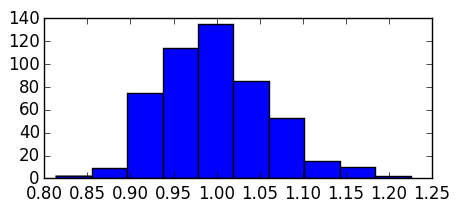

In [43]:
figure(figsize=(5, 2))
plt[:hist](Float64[d[1] for d in solutions]);

What is left is to code own MCMC sampler and start doing Bayesian FEM.

In this notebook the basic instructions how to develop JuliaFEM has been given. The most imporant concepts has been considered; how to develop own element with own basis, several ways how to define own equation, and how to finally assemble and calculate the problem using solver. Any comments and/or discussion about technical details, theory, programming etc. is very desirable; our issue log is in address https://github.com/JuliaFEM/JuliaFEM.jl/issues